In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

## 1. Load and merge data

In [2]:
# CUSTOMER id únic per cada línea de la taula (a priori no és útil), customer_unique_id client únic
customers_df = pd.read_csv('data/olist_customers_dataset.csv')
# ORDER and PRODUCT relationship, with price, seller, shipping, etc.
order_items_df = pd.read_csv('data/olist_order_items_dataset.csv')
orders_df = pd.read_csv('data/olist_orders_dataset.csv')
products_df = pd.read_csv('data/olist_products_dataset.csv')

In [3]:
orders_customers_df = pd.merge(orders_df, customers_df, on='customer_id', how='left')
# a partir d'aquí estem a nivell de PRODUCTE comprat
df = pd.merge(order_items_df, orders_customers_df, on='order_id', how='left')
df = pd.merge(df, products_df, on='product_id', how='left')

# Translate product category names to English
translation_df = pd.read_csv('data/product_category_name_translation.csv')
translation_dict = dict(zip(translation_df["product_category_name"], translation_df["product_category_name_english"]))
df["product_category_name"] = df["product_category_name"].replace(translation_dict)

## Exploratory

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date

def plot_orders_general(data, date_col):
    grouped = data.groupby([date_col]).size().reset_index(name="num_orders")
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=grouped, x='order_purchase', y='num_orders')
    plt.title("Orders by Day")
    plt.show()

def plot_orders_by_category(data, date_col, category_cols):
    data = data[data["product_category_name"].isin(category_cols)]
    grouped = data.groupby(["order_purchase","product_category_name"]).size().reset_index(name="num_orders")
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=grouped, x='order_purchase', y='num_orders', hue="product_category_name")
    plt.title("Orders per Category by Day")
    plt.show()


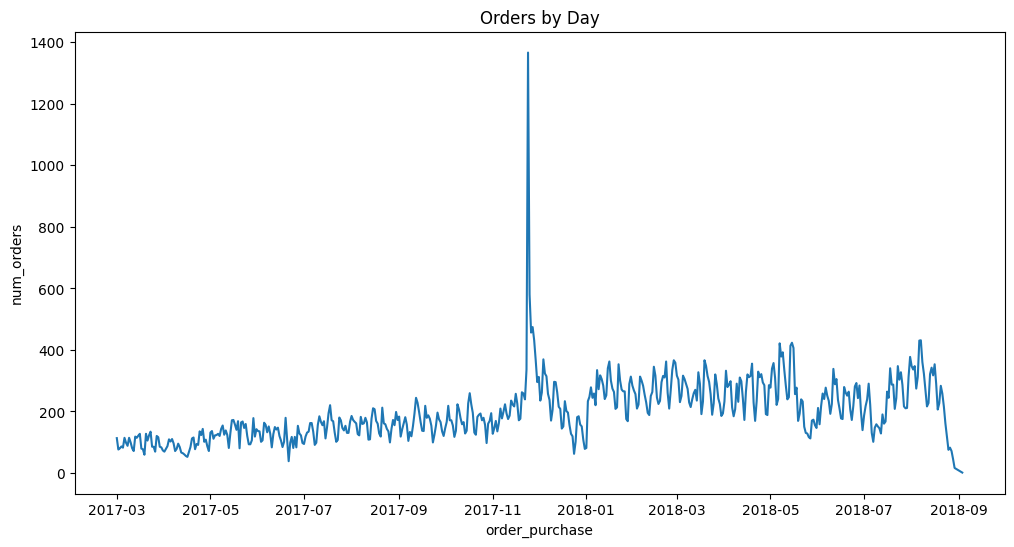

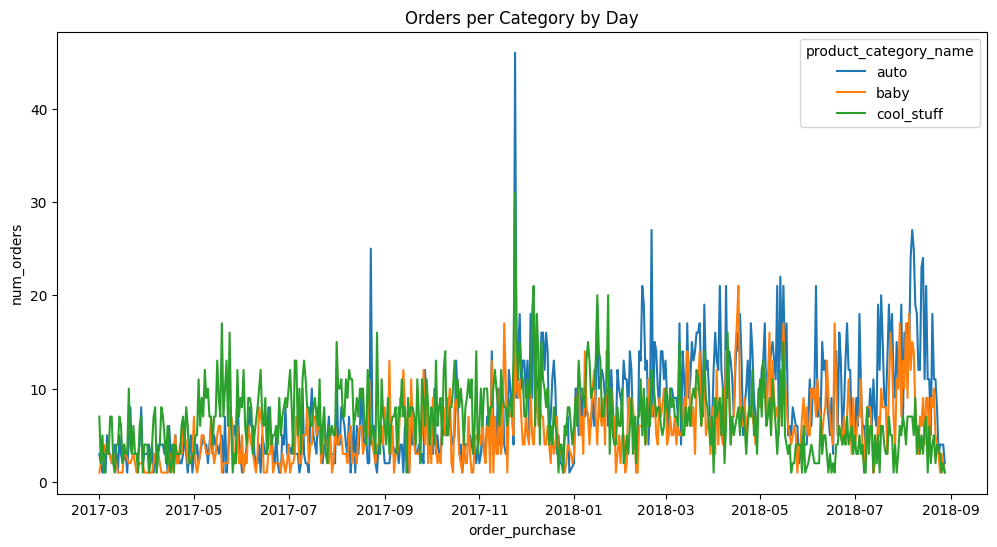

In [5]:
df = df[(df["order_purchase_timestamp"]>"2017-03-01") ].copy()
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])
df["order_purchase"] = pd.to_datetime(df["order_purchase_timestamp"]).dt.date

plot_orders_general(df, "order_purchase")
plot_orders_by_category(df, "order_purchase", ["auto","baby","cool_stuff"])

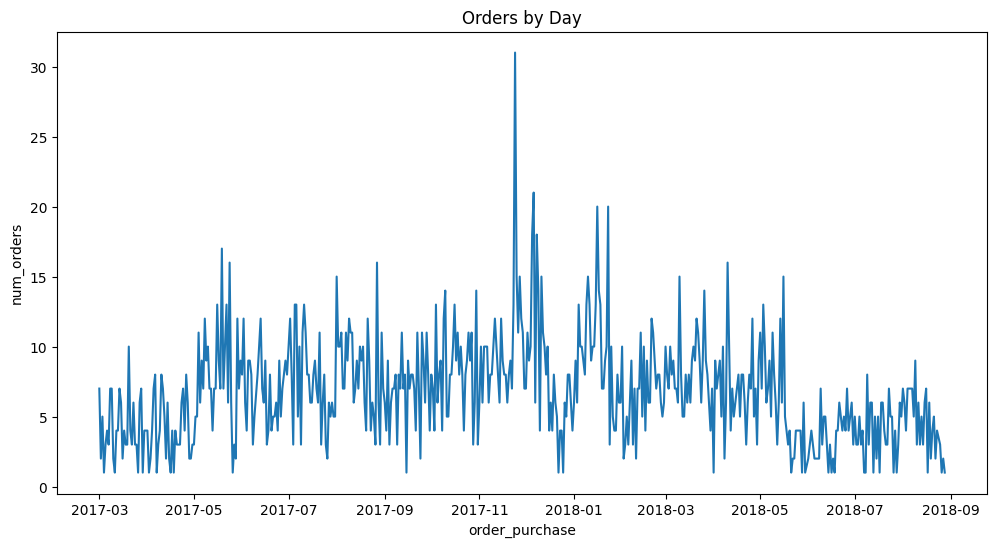

In [6]:
df = df[df["product_category_name"]=="cool_stuff"].reset_index(drop=True)
plot_orders_general(df, "order_purchase")


## Model - Forecasting Training

In [7]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint

2025-05-17 11:28:26.027927: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
spd_df = df.groupby(["order_purchase"]).size().reset_index(name="num_orders")
spd_df["order_purchase"] = pd.to_datetime(spd_df["order_purchase"])
# spd_df = spd_df.set_index("order_purchase").sort_index()
spd_df = spd_df[(spd_df["order_purchase"]>"2017-01-01") & (spd_df["order_purchase"]<"2018-08-01")]

In [9]:
def df_to_X_y(data, window_size, horizon):
    X, y = [], []
    for i in range(len(data)-window_size-horizon+1):
        X.append(data[i:i+window_size])
        y.append(data[i + window_size:i + window_size + horizon].flatten())
    return np.array(X), np.array(y)


In [12]:
WINDOW_SIZE = 30
HORIZON = 7

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(spd_df[['num_orders']])

X, y = df_to_X_y(scaled_data, WINDOW_SIZE, HORIZON)
X = X.reshape((X.shape[0], X.shape[1], 1))

X_train, y_train = X[:int(len(X)*0.8)], y[:int(len(y)*0.8)]
X_val, y_val = X[int(len(X)*0.8):int(len(X)*0.9)], y[int(len(y)*0.8):int(len(X)*0.9)]
X_test, y_test = X[int(len(X)*0.9):], y[int(len(y)*0.9):]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

model = Sequential([
    Input(shape=(WINDOW_SIZE, 1)),
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(HORIZON)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=RootMeanSquaredError())

model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=20)


(381, 30, 1) (381, 7)
(48, 30, 1) (48, 7)
(48, 30, 1) (48, 7)
Epoch 1/20
12/12 [==============================] - 13s 262ms/step - loss: 0.0488 - root_mean_squared_error: 0.2208 - val_loss: 0.0155 - val_root_mean_squared_error: 0.1246
Epoch 2/20
12/12 [==============================] - 0s 39ms/step - loss: 0.0208 - root_mean_squared_error: 0.1441 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1127
Epoch 3/20
12/12 [==============================] - 1s 75ms/step - loss: 0.0153 - root_mean_squared_error: 0.1236 - val_loss: 0.0160 - val_root_mean_squared_error: 0.1267
Epoch 4/20
12/12 [==============================] - 1s 48ms/step - loss: 0.0146 - root_mean_squared_error: 0.1207 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1202
Epoch 5/20
12/12 [==============================] - 0s 35ms/step - loss: 0.0143 - root_mean_squared_error: 0.1196 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1195
Epoch 6/20
12/12 [==============================] - 0s 29ms/step - loss: 0.0143 -

In [14]:
y_pred_scaled = model.predict(X_test)

y_pred = scaler.inverse_transform(y_pred_scaled)
y_actual = scaler.inverse_transform(y_test)

y_pred

2/2 [==============================] - 0s 9ms/step


array([[5.3733644, 5.0321827, 5.5079765, 6.0461216, 5.201323 , 5.4035306,
        5.9641404],
       [5.312252 , 4.9682655, 5.4568243, 5.995139 , 5.1425877, 5.3442144,
        5.9018908],
       [5.257291 , 4.9119678, 5.40789  , 5.944163 , 5.0905766, 5.29275  ,
        5.850655 ],
       [5.5449114, 5.2432528, 5.5893726, 5.9886928, 5.3727384, 5.648269 ,
        6.2147017],
       [5.5538445, 5.2600975, 5.6264477, 6.009847 , 5.3866014, 5.6598573,
        6.1709332],
       [5.702243 , 5.423031 , 5.7474136, 6.0609665, 5.5246882, 5.828228 ,
        6.306593 ],
       [5.8365135, 5.571635 , 5.868449 , 6.128168 , 5.6527557, 5.974574 ,
        6.4112635],
       [5.8240027, 5.5510654, 5.8934746, 6.166422 , 5.636169 , 5.9403167,
        6.3339586],
       [5.669679 , 5.368126 , 5.8053446, 6.148921 , 5.4783688, 5.7379065,
        6.11333  ],
       [5.648483 , 5.3384714, 5.7795277, 6.1327224, 5.4522047, 5.702729 ,
        6.0989847],
       [5.4868684, 5.1571913, 5.658593 , 6.0823846, 5.296511

In [15]:
y_actual

array([[2., 2., 7., 3., 5., 5., 3.],
       [2., 7., 3., 5., 5., 3., 1.],
       [7., 3., 5., 5., 3., 1., 3.],
       [3., 5., 5., 3., 1., 3., 1.],
       [5., 5., 3., 1., 3., 1., 2.],
       [5., 3., 1., 3., 1., 2., 1.],
       [3., 1., 3., 1., 2., 1., 4.],
       [1., 3., 1., 2., 1., 4., 4.],
       [3., 1., 2., 1., 4., 4., 6.],
       [1., 2., 1., 4., 4., 6., 4.],
       [2., 1., 4., 4., 6., 4., 5.],
       [1., 4., 4., 6., 4., 5., 4.],
       [4., 4., 6., 4., 5., 4., 7.],
       [4., 6., 4., 5., 4., 7., 4.],
       [6., 4., 5., 4., 7., 4., 5.],
       [4., 5., 4., 7., 4., 5., 6.],
       [5., 4., 7., 4., 5., 6., 3.],
       [4., 7., 4., 5., 6., 3., 5.],
       [7., 4., 5., 6., 3., 5., 3.],
       [4., 5., 6., 3., 5., 3., 3.],
       [5., 6., 3., 5., 3., 3., 5.],
       [6., 3., 5., 3., 3., 5., 3.],
       [3., 5., 3., 3., 5., 3., 4.],
       [5., 3., 3., 5., 3., 4., 1.],
       [3., 3., 5., 3., 4., 1., 1.],
       [3., 5., 3., 4., 1., 1., 8.],
       [5., 3., 4., 1., 1., 8., 3.],
 

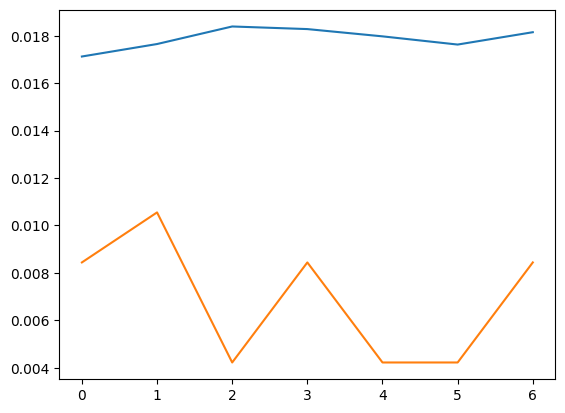

In [252]:
plt.plot(y_pred_test[20])
plt.plot(y_test[20].flatten())



## Next week

In [253]:
spd_last3 = spd_df[(spd_df["order_purchase"]>="2018-05-01")]
spd_last_week = spd_df[spd_df["order_purchase"]>="2018-07-25"]
spd_last_week

,order_purchase,num_orders
506,2018-07-25,5
507,2018-07-26,1
508,2018-07-27,4
509,2018-07-28,1
510,2018-07-29,3
511,2018-07-30,6
512,2018-07-31,5


In [254]:
X1, y1 = df_to_X_y(spd_last3["num_orders"], WINDOW_SIZE, HORIZON)
X1, y2 = scale_and_reshape(X1, y1)
X1.shape, y1.shape

((53, 30, 1), (53, 7))

In [255]:
y1

array([[3, 4, 3, 2, 2, 2, 2],
       [4, 3, 2, 2, 2, 2, 7],
       [3, 2, 2, 2, 2, 7, 3],
       [2, 2, 2, 2, 7, 3, 5],
       [2, 2, 2, 7, 3, 5, 5],
       [2, 2, 7, 3, 5, 5, 3],
       [2, 7, 3, 5, 5, 3, 1],
       [7, 3, 5, 5, 3, 1, 3],
       [3, 5, 5, 3, 1, 3, 1],
       [5, 5, 3, 1, 3, 1, 2],
       [5, 3, 1, 3, 1, 2, 1],
       [3, 1, 3, 1, 2, 1, 4],
       [1, 3, 1, 2, 1, 4, 4],
       [3, 1, 2, 1, 4, 4, 6],
       [1, 2, 1, 4, 4, 6, 4],
       [2, 1, 4, 4, 6, 4, 5],
       [1, 4, 4, 6, 4, 5, 4],
       [4, 4, 6, 4, 5, 4, 7],
       [4, 6, 4, 5, 4, 7, 4],
       [6, 4, 5, 4, 7, 4, 5],
       [4, 5, 4, 7, 4, 5, 6],
       [5, 4, 7, 4, 5, 6, 3],
       [4, 7, 4, 5, 6, 3, 5],
       [7, 4, 5, 6, 3, 5, 3],
       [4, 5, 6, 3, 5, 3, 3],
       [5, 6, 3, 5, 3, 3, 5],
       [6, 3, 5, 3, 3, 5, 3],
       [3, 5, 3, 3, 5, 3, 4],
       [5, 3, 3, 5, 3, 4, 1],
       [3, 3, 5, 3, 4, 1, 1],
       [3, 5, 3, 4, 1, 1, 8],
       [5, 3, 4, 1, 1, 8, 3],
       [3, 4, 1, 1, 8, 3, 6],
       [4,

In [256]:
y1_pred = model.predict(X1)
y1_pred

2/2 [==============================] - 0s 42ms/step


array([[0.0525538 , 0.03163924, 0.0299925 , 0.02598478, 0.02603993,
        0.03026848, 0.03280493],
       [0.0631576 , 0.02759917, 0.03289054, 0.02238796, 0.02747258,
        0.02742711, 0.02883686],
       [0.08498173, 0.02270323, 0.03922684, 0.01669153, 0.02889139,
        0.02366608, 0.02357507],
       [0.08033743, 0.02427271, 0.03780195, 0.01791824, 0.0279179 ,
        0.02441304, 0.02500106],
       [0.06217344, 0.02724356, 0.0318096 , 0.021765  , 0.02663475,
        0.02684096, 0.02847477],
       [0.05296156, 0.02750224, 0.02852863, 0.02321604, 0.02670823,
        0.02756887, 0.02935846],
       [0.04869016, 0.0264203 , 0.02680623, 0.02329323, 0.02727571,
        0.02720271, 0.02882594],
       [0.04716874, 0.02484052, 0.02597695, 0.02271242, 0.02801064,
        0.02637791, 0.02765821],
       [0.12496889, 0.00957486, 0.05050988, 0.00399893, 0.0319916 ,
        0.01576248, 0.01096085],
       [0.1012366 , 0.01845809, 0.04420476, 0.0115479 , 0.02798089,
        0.02063047, 0.0

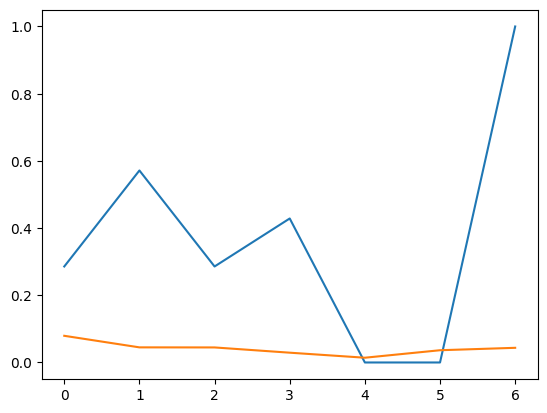

In [257]:
plt.plot(y2[30])
plt.plot(y1_pred[30])


In [259]:
y1_pred_reescaled = scaler.inverse_transform(y1_pred)
y1_pred_last_week = y1_pred_reescaled[52]
y1_pred_last_week

array([1.8844607, 1.2173012, 1.413133 , 1.109899 , 1.1391666, 1.19183  ,
       1.2050669], dtype=float32)

/var/folders/8r/1332ysds69x9bgfxqnpscj8c0000gn/T/ipykernel_6537/45576743.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[date_column] = pd.to_datetime(data[date_column])


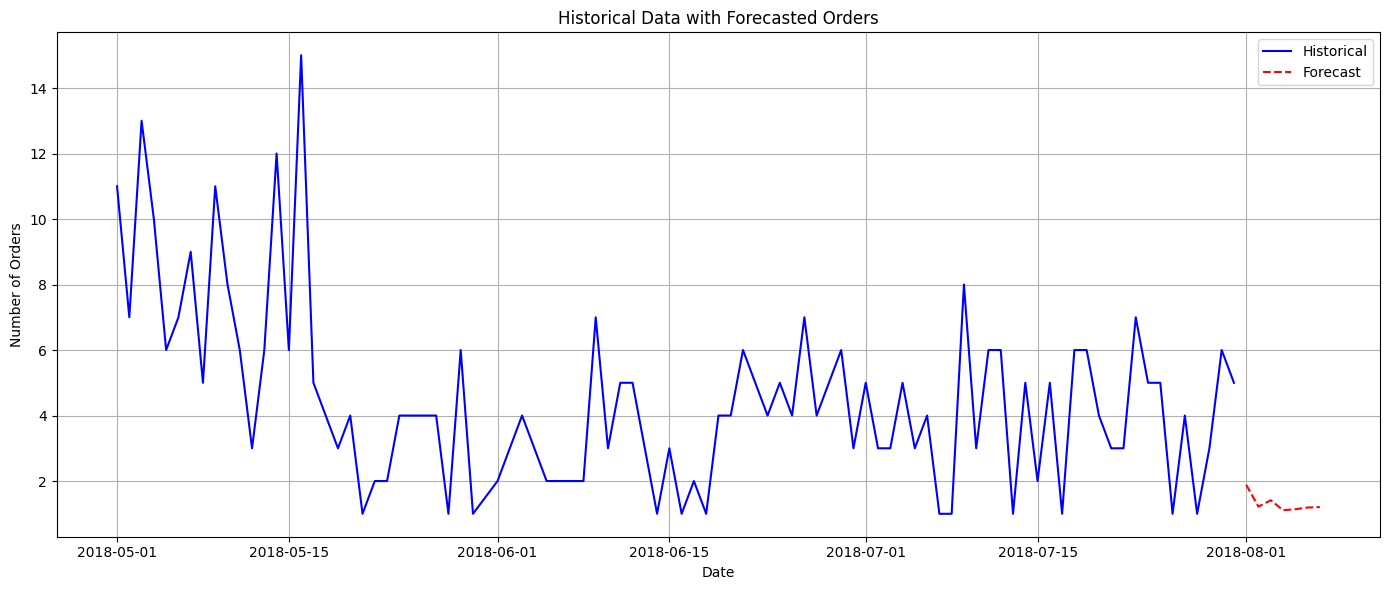

In [260]:
def plot_forecast(data, future_preds, date_column='order_purchase', value_column='num_orders'):
    """
    Plots the original time series along with forecasted future values.

    Parameters:
    - spd_df: Original DataFrame with date and order columns.
    - future_preds: List or array of forecasted values (in original scale).
    - date_column: Column name containing the dates.
    - value_column: Column name containing the values (e.g., 'num_orders').
    """

    # Convert dates
    data[date_column] = pd.to_datetime(data[date_column])
    historical_dates = data[date_column]
    historical_values = data[value_column]

    # Generate future dates
    last_date = historical_dates.iloc[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=len(future_preds))

    # Plot
    plt.figure(figsize=(14, 6))
    plt.plot(historical_dates, historical_values, label='Historical', color='blue')
    plt.plot(future_dates, future_preds, label='Forecast', color='red', linestyle='dashed')
    plt.xlabel('Date')
    plt.ylabel('Number of Orders')
    plt.title('Historical Data with Forecasted Orders')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_forecast(spd_last3, y1_pred_last_week, date_column='order_purchase', value_column='num_orders')
